In [1]:
import os
import logging
from time import time, localtime
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import TimeDistributed, Conv1D, MaxPool1D, Flatten, LSTM, Dense, AveragePooling1D
from keras.models import Sequential
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


2022-11-17 08:37:11.377760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 08:37:11.841591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 08:37:11.841613: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 08:37:11.903278: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 08:37:13.087692: W tensorflow/stream_executor/pla

Lựa chọn model <br>
Thay models.<Ten_model>

In [2]:
from models.CNNv5 import create_keras_model


Thay đổi các siêu tham số trong cell dưới <br>
**experiment_name:** Tên bộ dữ liệu được sử dụng, <Tên dữ liệu>_<Số byte sử dụng> <br>
**method:** Mô hình sử dụng <br>
**client_lr, server_lr:** Learning rate của client và server, khi fine tune bắt đầu từ 1 và giảm dần xuống 3e-4 <br>
**NUM_ROUNDS:** Số vòng lặp (Bắt đầu từ 1 và tăng dần lên 3000 nếu mô hình chưa hội tụ - 1/100/200/300/400/500/.../3000) <Br>
**BATCH_SIZE:** Kích thước batch (Bắt đầu từ 8 và tăng dần lên 64) 8/16/32/64 <br>
**split:** Để nguyên là 5

byte_number (string): Cac byte cua packet, bao gom 10, 32, 64, 128, 256, 512, 1024, 1460

In [3]:
byte_number = "512"


In [4]:
experiment_name = "GQUIC_" + byte_number
method = "CNNv5"
client_lr = 3e-4
server_lr = 3e-4
NUM_ROUNDS = 1000
BATCH_SIZE = 32
split = 5


In [5]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [6]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


In [7]:
def most_frequent(List):
    return max(set(List), key=List.count)


### Đọc dữ liệu

In [8]:
train_dir = '/home/onos/FL/Data Processing/GQUIC_data_' + byte_number + '.csv'
test_dir = '/home/onos/FL/Data Processing/GQUIC_test_' + byte_number + '.csv'
data = pd.read_csv(train_dir, engine='pyarrow')
test = pd.read_csv(test_dir, engine='pyarrow')


In [9]:

result = test.groupby('flow_id')['Label'].apply(list).to_dict()
flow_label = []
for flow in result:
    flow_label.append(most_frequent(result[flow]))


In [10]:
true_test = test.drop('flow_id', axis=1)


In [11]:
NUM_FEATURE = len(true_test.columns)-1
NUM_CLASSES = len(np.unique(true_test['Label']))
print(NUM_FEATURE, NUM_CLASSES)


513 4


In [12]:
total_data_count = data.shape[0]
data_per_set = int(np.floor(total_data_count/split))


In [13]:
x_test = true_test.drop('Label', axis=1).to_numpy()


In [14]:
data = data.sample(frac=1).reset_index(drop=True)


In [15]:
DataFrameDict = {}
for i in range(1, split+1):
    client_name = "client_" + str(i)
    start = data_per_set * (i-1)
    end = data_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    DataFrameDict[client_name] = data[start:end]


Adding data from 0 to 170579 for client : client_1
Adding data from 170579 to 341158 for client : client_2
Adding data from 341158 to 511737 for client : client_3
Adding data from 511737 to 682316 for client : client_4
Adding data from 682316 to 852895 for client : client_5


In [16]:
# def sklearn_to_df(sklearn_dataset):
#     df = pd.DataFrame(sklearn_dataset.data,
#                       columns=sklearn_dataset.feature_names)
#     df['Label'] = pd.Series(sklearn_dataset.Label)
#     return df


In [17]:
# from sklearn import datasets
# df = sklearn_to_df(datasets.load_iris())


## Federated Learning Approach

### Data Loading

In [18]:
def make_tf_dataset(dataframe, batch_size=None):

    y = dataframe.pop('Label')

    # Dataset creation
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe.values, y.to_frame().values))
    dataset = dataset.shuffle(2048, seed=SEED)
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset


In [19]:
train_data, val_data = [], []
for client_data in DataFrameDict.keys():
    train_df, val_df = train_test_split(
        DataFrameDict[client_data], test_size=0.2, random_state=SEED)

    train_features = train_df.drop(['Label'], axis=1)
    val_features = val_df.drop(['Label'], axis=1)

    train_df[train_df.columns.difference(['Label'])] = train_features
    val_df[val_df.columns.difference(['Label'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df, batch_size=BATCH_SIZE))
    val_data.append(make_tf_dataset(val_df, batch_size=1))


2022-11-17 08:39:17.699822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-17 08:39:17.700283: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-17 08:39:17.700306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onos-virtual-machine): /proc/driver/nvidia/version does not exist
2022-11-17 08:39:17.703605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model Definition

In [20]:
def input_spec():
    return (
        tf.TensorSpec([None, NUM_FEATURE], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )


In [21]:
def model_fn():
    model = create_keras_model(NUM_FEATURE, NUM_CLASSES)

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


### Training

Each time the `next` method is called, the server model is broadcast to each client using a broadcast function. For each client, one epoch of local training is performed. Each client computes the difference between the client model after training and the initial broadcast model. These model deltas are then aggregated at the server using some aggregation function.

In [22]:
tff_train_acc = []
tff_train_loss = []
tff_val_acc = []
tff_val_loss = []


In [23]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(
        learning_rate=client_lr),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(
        learning_rate=server_lr)
)


In [24]:
evaluator = tff.learning.build_federated_evaluation(model_fn)


In [25]:
state = iterative_process.initialize()


In [26]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%y_%m_%d_%H_%M")
print("Current Time =", current_time)


Current Time = 22_11_17_08_44


In [27]:
current_round = None


In [28]:
# ckpt_manager = FileCheckpointManager(
#     model_dir/"22_10_31_02_09"/"{}_{}".format(experiment_name, method))
# state,current_round = ckpt_manager.load_latest_checkpoint(state)


In [29]:
ckpt_manager = FileCheckpointManager(
    model_dir/current_time/"{}_{}".format(experiment_name, method), keep_total=10)


In [30]:
if not current_round:
    current_round = 0


In [31]:
start = time()
for i in range(current_round, NUM_ROUNDS):
    # Train
    result = iterative_process.next(state, train_data)
    state = result.state
    train_metrics = result.metrics['client_work']['train']

    # Validation
    federated_metrics = evaluator(result.state.global_model_weights, val_data)
    val_metrics = federated_metrics['eval']

    # Metrics
    train_loss = train_metrics['loss']
    train_acc = train_metrics['sparse_categorical_accuracy']
    val_loss = val_metrics['loss']
    val_acc = val_metrics['sparse_categorical_accuracy']

    # Print
    print('round {:2d}\ntrain_loss={l:.3f}, train_acc={ac:.3f}'.format(
        i+1, l=train_loss, ac=train_metrics['sparse_categorical_accuracy']))
    print('val_loss: {:.3f} val_acc: {:.3f}'.format(
        val_loss, val_acc))

    # Save
    ckpt_manager.save_checkpoint(state, round_num=i)
    # logs
    tff_train_acc.append(float(train_metrics['sparse_categorical_accuracy']))
    tff_train_loss.append(float(train_metrics['loss']))
    tff_val_acc.append(float(val_metrics['sparse_categorical_accuracy']))
    tff_val_loss.append(float(val_metrics['loss']))
    current_round = i

end = time() - start


round  1
train_loss=1.098, train_acc=0.476
val_loss: 1.341 val_acc: 0.364
round  2
train_loss=1.095, train_acc=0.477
val_loss: 1.318 val_acc: 0.379
round  3
train_loss=1.093, train_acc=0.478
val_loss: 1.306 val_acc: 0.380
round  4
train_loss=1.091, train_acc=0.479
val_loss: 1.296 val_acc: 0.381
round  5
train_loss=1.089, train_acc=0.480
val_loss: 1.289 val_acc: 0.381
round  6
train_loss=1.088, train_acc=0.481
val_loss: 1.283 val_acc: 0.382
round  7
train_loss=1.086, train_acc=0.482
val_loss: 1.277 val_acc: 0.382
round  8
train_loss=1.085, train_acc=0.483
val_loss: 1.273 val_acc: 0.384
round  9
train_loss=1.084, train_acc=0.483
val_loss: 1.269 val_acc: 0.385
round 10
train_loss=1.082, train_acc=0.485
val_loss: 1.265 val_acc: 0.386
round 11
train_loss=1.081, train_acc=0.486
val_loss: 1.262 val_acc: 0.387
round 12
train_loss=1.080, train_acc=0.486
val_loss: 1.260 val_acc: 0.388
round 13
train_loss=1.079, train_acc=0.486
val_loss: 1.258 val_acc: 0.393
round 14
train_loss=1.078, train_acc=0

KeyboardInterrupt: 

In [32]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 236 hours 54 mins 55 seconds


In [33]:
train_val = str(round(train_acc*100)) + "_" + str(round(val_acc*100))


In [34]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


### Evaluation

In [35]:
ckpt_manager = FileCheckpointManager(model_dir)
try:
    ckpt_manager.save_checkpoint(state, round_num=current_round)
except:
    print("File exist")


In [36]:
# # Cai nay de test, xoa sau khi dung xong
# this_dir = Path.cwd()
# model_dir = this_dir / "sdn_saved_models" / experiment_name / method / '18_15'
# output_dir = this_dir / "sdn_results" / experiment_name / method / "18_15"

# if not model_dir.exists():
#     model_dir.mkdir(parents=True)

# if not output_dir.exists():
#     output_dir.mkdir(parents=True)


In [37]:
# ckpt_manager = FileCheckpointManager('/home/onos/FL/sdn_saved_models/GQUIC/CNNv2/18_15')
# state,current_round = ckpt_manager.load_latest_checkpoint(state)


In [38]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nserver_lr: {}\nRounds: {}\nBATCH_SIZE: {}'.format(
        client_lr, server_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()


In [39]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()


In [40]:
model_for_inference = create_keras_model(NUM_FEATURE, NUM_CLASSES)
state.global_model_weights.assign_weights_to(model_for_inference)


In [41]:
predictions = model_for_inference.predict(x_test, batch_size=64)


3332/3332 [==============================] - 59s 18ms/step


In [42]:
y_pred = np.argmax(predictions, axis=-1)
test['pred'] = y_pred.tolist()


In [43]:
result = test.groupby('flow_id')['pred'].apply(list).to_dict()
flow_pred = []
for flow in result:
    flow_pred.append(most_frequent(result[flow]))


In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


classes = []
for c in range(NUM_CLASSES):
    classes.append("Class {}".format(c))
print(classes)
with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(flow_label, flow_pred)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(flow_label, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(flow_label, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(flow_label, flow_pred, target_names=classes), file=f)
    f.close()


['Class 0', 'Class 1', 'Class 2', 'Class 3']


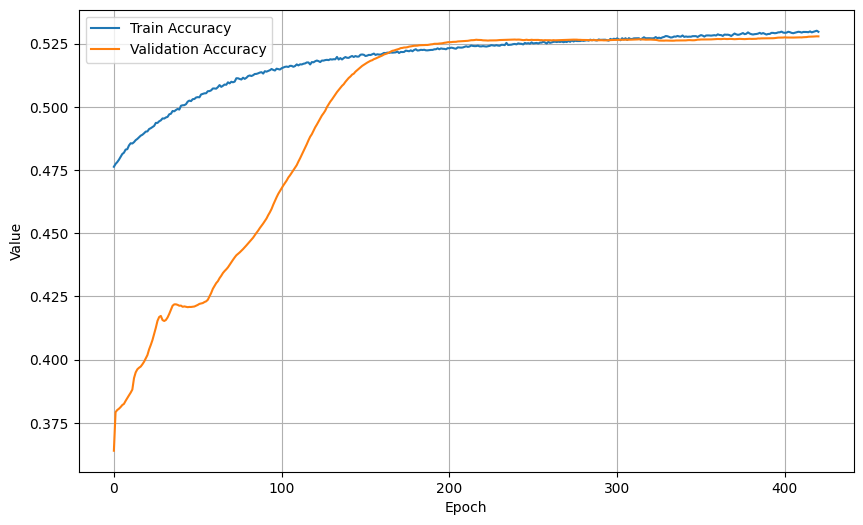

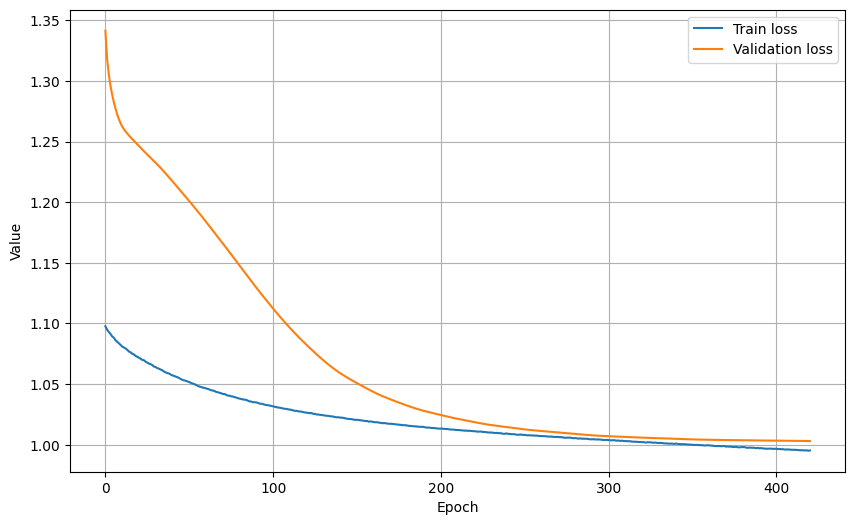

In [45]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(0, current_round+1)),
           tff_train_acc, label='Train Accuracy')
plot_graph(list(range(0, current_round+1)), tff_val_acc,
           label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(0, current_round+1)), tff_train_loss, label='Train loss')
plot_graph(list(range(0, current_round+1)),
           tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")


## Single Model with all Data at once (for comparison)

### Data Loading

In [46]:
# train_data = train_data[0].concatenate(train_data[1])
# val_data = val_data[0].concatenate(val_data[1])


### Model Definition

In [47]:
# def model_fn():
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(4,)),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(3, activation='sigmoid'),
#     ])

#     model.compile(
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#         optimizer=tf.keras.optimizers.Adam(),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
#     )

#     return model


### Training

In [48]:
# model = model_fn()
# history = model.fit(train_data, epochs=NUM_ROUNDS,verbose=0)


### Evaluation

In [49]:
# test_scores = model.evaluate(val_data)
# single_metrics = {
#     'loss': test_scores[0],
#     'accuracy': test_scores[1],
# }
# single_metrics


## Conclusion

Comparing both models:

In [50]:
# print(f"---Single model metrics---\n{single_metrics}\n")
# print(f"---Federated model metrics---\n{dict(federated_metrics)}")


The Federated Learning approach has a better balance between precision and recall, which might be an indicator of better handling of the imbalanced dataset.